# Load and test the trained model

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# This notebook is based on the example of Convolutional Variational Autoencoder (CVAE)
# on tensorflow.org/tutorials/generative/cvae

## Setup

In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp

Assign device (GPU)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load data

### Test set

In [5]:
# minimum sq
sq_min = np.exp(-5)

In [6]:
if 0:
    X_file = '../data/input_grid_all_GPR80.csv'
    Y_file = '../data/target_grid_all.csv'
else:
    X_file = '../data/input_random_all_GPR80.csv'
    Y_file = '../data/target_random_all.csv'
    
fX_test = open(X_file, 'r', encoding='utf-8-sig')
sq_test = np.genfromtxt(fX_test, delimiter=',').astype(np.float32)
sq_test[sq_test<=0] = sq_min

fY_test = open(Y_file, 'r', encoding='utf-8-sig')
target_test = np.genfromtxt(fY_test, delimiter=',').astype(np.float32)

In [7]:
sq_test.shape

(15000, 80)

In [8]:
eta_test = target_test[:, 0]
kappa_test = target_test[:, 1]
Z_test = target_test[:, 3]
A_test = target_test[:, 2]
lnZ_test = np.log(Z_test)
lnA_test = np.log(A_test)

In [9]:
sq_dim = sq_test.shape[1]
sample_test_dim = sq_test.shape[0]

$Q\cdot r_\textrm{ave}$

In [10]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

Rescale

In [11]:
r_eta_test = 1
sq_test_rs = np.zeros((sample_test_dim,q_rs_dim),dtype='float32')
for i in range(sample_test_dim):
    qr_eta = q*r_eta_test
    interpolating_function_test = interp.interp1d(qr_eta[3:],sq_test[i,3:],
                                                  fill_value='extrapolate',kind='linear')
    sq_test_rs[i,:] = interpolating_function_test(q_rs)
sq_test_rs[sq_test_rs<=0] = sq_min

### Mask

In [12]:
mask_length = 0
sq_test_mask = sq_test_rs

for i in range(sample_test_dim):
    sq_test_mask[i,0:mask_length] = sq_test_mask[i,mask_length]

### Preprocess/Postprocess

In [13]:
exp_scale = 3

def f_inp(sq):
    return np.log(sq)/exp_scale/2 + 0.5

def f_out(predictions):
    return np.exp((predictions*2-1)*exp_scale)

### Shuffle data

In [14]:
test_size = sq_test.shape[0]
batch_size_test = 16
num_examples_to_generate = 16

# noises
m_noise = 0.01
test_dataset = (tf.data.Dataset.from_tensor_slices(f_inp(sq_test_mask)
                +(np.random.rand(sq_test_mask.shape[0],sq_test_mask.shape[1])-0.5)*m_noise)
                .shuffle(test_size, seed=74).batch(sample_test_dim))

In [15]:
# Pick a sample of the test set for generating output images
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :]
test_sample.shape

TensorShape([16, 80])

## Network architecture

In [16]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = None
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                name='conv1d_en'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                40*32, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(40, 32)),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [17]:
latent_dim = 3
model = VAE(latent_dim, q_rs_dim)

## Load and test model

In [18]:
export_path = './saved_model/SQ_cVAE_MSE_ns/'
model_name = 'model_conv_stride2_GPR'
export_name = export_path + model_name

In [19]:
reload_sm = model.load_weights(export_name, by_name=False, skip_mismatch=False, options=None)
reload_sm.__dict__

{'_checkpoint': <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator at 0x2b3dfc81e20>,
 '_feed_dict': None,
 '_graph_view': <tensorflow.python.training.tracking.graph_view.ObjectGraphView at 0x2b3dea85760>,
 '_root': <__main__.VAE at 0x2b3dd0d4ca0>}

In [20]:
model_r = reload_sm._root
#model_r.__dict__

### Loaded network architecture

In [21]:
class VAE_r():
    def __init__(self):
        self.encoder = model_r.encoder
        self.decoder = model_r.decoder
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
M = VAE_r() # loaded model

In [22]:
def generate_test_images(model, test_sample):
    mean, logvar = model.encode(test_sample)
    z0 = mean
    predictions_0 = model.sample(z0)
    fig = plt.figure(figsize=(8, 8))
    
    # Confident interval
    n_sample = 100
    predictions_n = np.zeros((tf.size(test_sample),n_sample))
    for i in range(n_sample):
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        predictions_n[:,i] = tf.reshape(predictions,tf.size(test_sample))
        
    predictions_m = np.zeros(tf.size(test_sample))
    predictions_v = np.zeros(tf.size(test_sample))
    for j in range(tf.size(test_sample)):
        predictions_m[j] = np.mean(predictions_n[j,:])
        predictions_v[j] = np.var(predictions_n[j,:])
        
    predictions_mean = tf.reshape(predictions_m,test_sample.shape)
    predictions_var = tf.reshape(predictions_v,test_sample.shape)
    predictions_std = np.sqrt(predictions_var)
    
    if 0:
        window = 11
        from scipy.signal import savgol_filter as sf
        predictions_mean = sf(predictions_mean, window, 3)
        predictions_std = sf(predictions_std, window, 3)
    
    predictions_u = predictions_mean + predictions_std
    predictions_l = predictions_mean - predictions_std
        
    # plot
    for i in range(test_sample.shape[0]):
        plt.subplot(4, 4, i + 1)
        #plt.plot(q_rs,f_out(predictions_0[i,:]),'b')   
        plt.plot(q_rs,f_out(predictions_mean[i,:]),'b')   
        #plt.plot(q_rs,f_out(predictions_u[i,:]),'c')  
        #plt.plot(q_rs,f_out(predictions_l[i,:]),'c')
        plt.fill_between(q_rs,f_out(predictions_u[i,:]),f_out(predictions_l[i,:]),color='c',alpha=0.5)
        plt.plot(q_rs,f_out(test_sample[i,:]),'k')
        #plt.axis('off')
        plt.ylim(0, 3)

    # tight_layout minimizes the overlap between 2 sub-plots
    pngname = './figures_SQ_cVAE_MSE_ns/test_SQ_cVAE_MSE_ns.png'
    plt.savefig(pngname)
    plt.show()

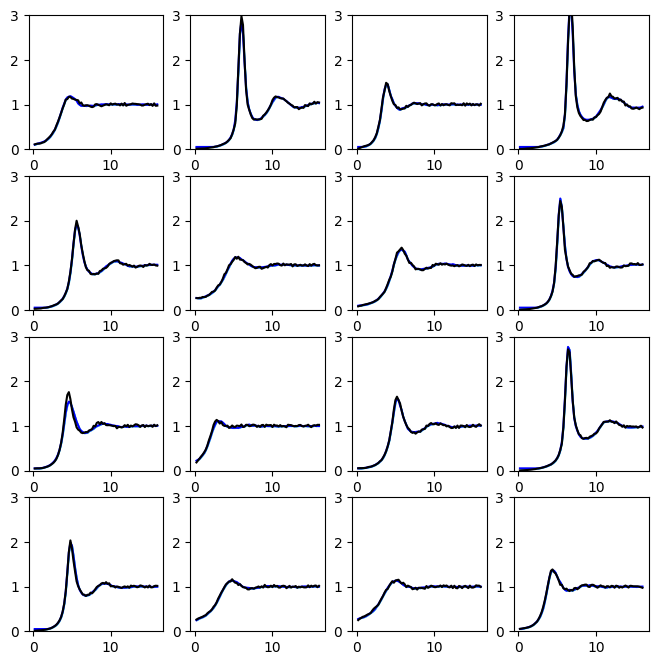

In [23]:
generate_test_images(M, test_sample)